# Linear Regression using stock market data and stock technical indicators

This is a simple example using Linear Regression to predict stock prices. Stock data is loaded from the web using pandas datareader, a few features are added, and predictions are made using Linear Regression.

Secondly, multiple features are added (although not throughly thought out) by calculating technical indicators using TA-Lib. Normally this is not recommended as it leads to overfitting (and quite possibly just creating a lot of noise).

When time permits, I will dive deeper into the technical indicators, apply them properly, and use backward elimination to find those that add value to the model.

In [15]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import warnings
import datetime
from datetime import datetime as dt, timedelta
import time
warnings.filterwarnings('ignore')

# machine learning...
from sklearn import preprocessing, svm, cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# visualization...
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

# to calculate technical indicators
import talib
from talib.abstract import *

matplotlib.style.use('ggplot')
import sys

## Load open, high, low, close data for Apple

Load data for Apple using pandas datareader (Investors Exchange data)
 - more info: http://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-iex

In [51]:
ticker = "AAPL"
start = dt.today() - timedelta(days=5*365)
end = dt.now()

df = web.DataReader(ticker, 'iex', start, end) 

# convert index to datetime...
df.index = pd.to_datetime(df.index)

df.info()
df.tail()
df.index

5y
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-06-17 to 2018-06-14
Data columns (total 5 columns):
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


DatetimeIndex(['2013-06-17', '2013-06-18', '2013-06-19', '2013-06-20',
               '2013-06-21', '2013-06-24', '2013-06-25', '2013-06-26',
               '2013-06-27', '2013-06-28',
               ...
               '2018-06-01', '2018-06-04', '2018-06-05', '2018-06-06',
               '2018-06-07', '2018-06-08', '2018-06-11', '2018-06-12',
               '2018-06-13', '2018-06-14'],
              dtype='datetime64[ns]', name='date', length=1259, freq=None)

## Display as candlestick

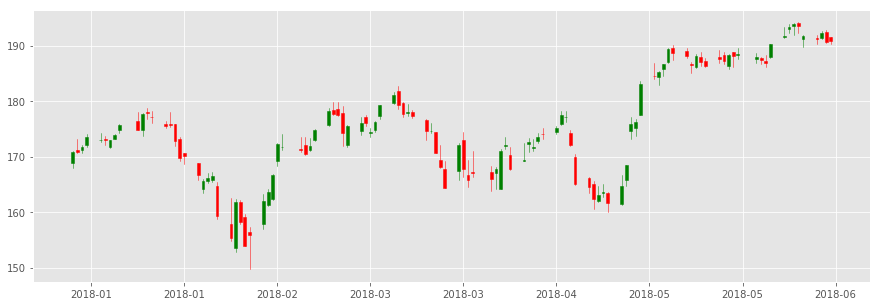

In [17]:
# pull date out of index and convert
df['date']= matplotlib.dates.date2num(df.index.to_pydatetime())

# plot from beginning of year...
start = matplotlib.dates.datestr2num('2018-01-01')

# dataframe to plot
ohlc =  df[['date','open','high','low','close']][df.date > start]
f1, ax = plt.subplots(figsize = (15,5))

# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

# drop date column used for plot
df = df.drop('date', axis=1)

In [4]:
print(df['20180501':pd.to_datetime('today')].close)

date
2018-05-01    168.4505
2018-05-02    175.8918
2018-05-03    176.2106
2018-05-04    183.1239
2018-05-07    184.4488
2018-05-08    185.3354
2018-05-09    186.6404
2018-05-10    189.3101
2018-05-11    188.5900
2018-05-14    188.1500
2018-05-15    186.4400
2018-05-16    188.1800
2018-05-17    186.9900
2018-05-18    186.3100
2018-05-21    187.6300
2018-05-22    187.1600
2018-05-23    188.3600
2018-05-24    188.1500
2018-05-25    188.5800
2018-05-29    187.9000
2018-05-30    187.5000
2018-05-31    186.8700
2018-06-01    190.2400
2018-06-04    191.8300
2018-06-05    193.3100
2018-06-06    193.9800
2018-06-07    193.4600
2018-06-08    191.7000
Name: close, dtype: float64


## Add a few Features to the data (later we'll add plenty more!)

In [52]:
# high low %...
df['highlow_pct'] = (df['high'] - df['low']) / (df['low']*100)

# percent change...
df['pct_change'] = (df['close'] - df['open']) / (df['open']*100)

# return...
df['return']  =np.log(df['open'] / df['open'].shift(1))
df.dropna(inplace=True)

## Prepare the data for classification
- set the target column (dependant variable)
- how many days forward to predict

Next, add a new column target_close that contains the close price n days into the future (n=prediction_days)


#### Feature Matrix
create a feature matrix with all the columns except target_close and scale the data

In [53]:
# set feature matrix to all columns (last row may not contain a price for close...ignore)
X = np.array(df.drop(df.index[len(df)-1]))
print(X[1:])

# scale features using sklearn preprocessing scale
#X = preprocessing.scale(X)
#print(X[1:])

[[  5.62554000e+01   5.62893000e+01   5.51600000e+01 ...,   2.04731690e-04
   -1.94719085e-04  -3.71450893e-04]
 [  5.46775000e+01   5.55486000e+01   5.41390000e+01 ...,   2.60366834e-04
   -5.87078780e-05  -2.84497462e-02]
 [  5.45719000e+01   5.47688000e+01   5.32171000e+01 ...,   2.91579210e-04
   -1.19237190e-04  -1.93319200e-03]
 ..., 
 [  1.91350000e+02   1.91970000e+02   1.90210000e+02 ...,   9.25293097e-05
   -6.27123073e-06   9.41127331e-04]
 [  1.91385000e+02   1.92611000e+02   1.91150000e+02 ...,   7.64321214e-05
    4.67643755e-05   1.82894170e-04]
 [  1.92420000e+02   1.92880000e+02   1.90440000e+02 ...,   1.28124344e-04
   -8.93877975e-05   5.39337689e-03]]


Set y to the close -1 day (this is what the model will predict)

In [54]:
y = df['close'].shift(-1)
y.drop(y.index[len(y)-1], inplace=True)
y = np.array(y)

### Create Test and Train sets
Use Cross validation to split into test and train data)

In [55]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=42)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  1005 252


## Classify with Linear Regression

In [56]:
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.997498012633


### Get the predictions

In [57]:
predictions = clf.predict(X_test)
print(predictions)

[ 186.88560789  117.08681332   99.06003269  104.49238418  111.55547411
  119.76324061  159.92620377  113.69376272  107.47534608  165.22478416
  118.71661626  109.08465807   96.29449235   95.30934289  108.35218397
  155.55315918  112.81599961   64.33891066  112.68279811  109.26415129
  116.50660676  167.38542017   60.61629804  111.7897827   121.13737161
   96.29664136  144.26114385   87.40082531   94.93348823   90.66384934
  139.46353959  154.25076293  146.26699603  146.44261616   71.11662286
  169.15404195  106.54470983   66.07594458   92.89526637  102.32800324
  106.41594795  113.62470036  170.65317491   78.76116557  105.52115416
  134.03726592  113.9473019   108.79350712   73.41357222  109.46004597
  166.52673142   91.06365323   89.91411677  104.94572209  112.52685959
   65.27244431   79.30456213  119.47053208  151.59945698  151.101908
  109.88799464   69.32751894  152.52245847   94.44596566  188.41840136
  109.95361601  113.32035487  124.73648328   97.21747805   94.65331634
  106.17

## Predict the last 30 days

In [58]:
# get last 30 days...
test = df.ix[-30:,]  

result = df.ix[-30:]  

# save last 30 days predictions
result['Predicted'] =  clf.predict(test)

# Plot the predictions with the actual close

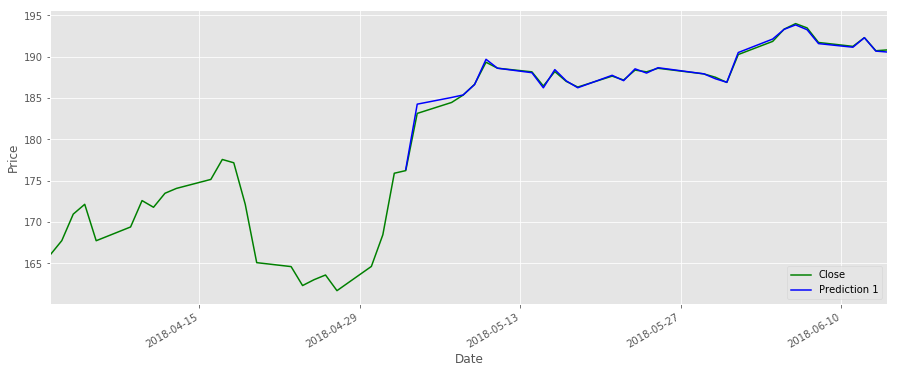

In [59]:
df_plot = pd.DataFrame(df['close'])
df_plot = df_plot.join(result['Predicted'])

df_plot['20180401':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green", label='Close') 
df_plot['20180401':pd.to_datetime('today')]['Predicted'].plot(figsize=(15,6), color="blue", label='Prediction 1') 

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Further Feature Engineering
### Technical Analysis Indicators
Now, brute force a bunch of stock indicators as features and re-classify.  Normally you would apply domain knowledge to properly setup each indicator and then go through the process of features elimination, but in order to save time lets just plow in a bunch of indicators to see if the prediction improves.

Indicators were generated using TA-Lib (https://mrjbq7.github.io/ta-lib/).  In all cases the defaults were used for all functions.

### Function to generate features

In [65]:
# Overlap Studies Functions
bb = BBANDS(df, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['bbup'] = bb.upperband
df['bbmid'] = bb.middleband
df['bblow'] = bb.lowerband
df['DEMA'] = DEMA(df, timeperiod=30)
df['EMA'] = EMA(df, timeperiod=30)
df['HT_TRENDLINE'] = HT_TRENDLINE(df)
df['KAMA'] = KAMA(df, timeperiod=30)
df['MA'] = MA(df, timeperiod=30, matype=0)
df['MIDPOINT'] = MIDPOINT(df, timeperiod=14)
df['MIDPRICE'] = MIDPRICE(df, timeperiod=14)
df['SAR'] = SAR(df, acceleration=0, maximum=0)
df['SAREXT'] = SAREXT(df, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
df['SMA'] = SMA(df, timeperiod=30)
df['T3'] = T3(df, timeperiod=5, vfactor=0)
df['TEMA'] = TEMA(df, timeperiod=30)
df['TRIMA'] = TRIMA(df, timeperiod=30)
df['WMA'] = WMA(df, timeperiod=30)
#
# Momentum Indicator Functions
#
df['ADX'] = ADX(df, timeperiod=14)
df['APO'] = APO(df, fastperiod=12, slowperiod=26, matype=0)
dftemp = AROON(df, timeperiod=14)
df['AroonDown'] = dftemp.aroondown
df['AroonUp'] = dftemp.aroonup
df['AroonOsc'] = AROONOSC(df, timeperiod=14)
df['BOP'] = BOP(df)
df['CCI'] = CCI(df, timeperiod=14)
df['CMO'] = CMO(df, timeperiod=14)
df['DX'] = DX(df, timeperiod=14)
dftemp =  MACDFIX(df, signalperiod=9)
df['MACD'] = dftemp.macd
df['MACDsignal'] = dftemp.macdsignal
df['MACDhist'] = dftemp.macdhist
df['MINUS_DI'] = MINUS_DI(df, timeperiod=14)
df['MINUS_DM'] = MINUS_DM(df, timeperiod=14)
df['PLUS_DI'] = PLUS_DI(df, timeperiod=14)
df['PLUS_DM'] = PLUS_DM(df, timeperiod=14)
df['PPO'] = PPO(df, fastperiod=12, slowperiod=26, matype=0)
df['ROC'] = ROC(df, timeperiod=10)
df['ROCP'] = ROCP(df, timeperiod=10)
df['ROCR'] = ROCR(df, timeperiod=10)
df['ROCR100'] = ROCR100(df, timeperiod=10)
df['RSI'] = RSI(df, timeperiod=14)
dftemp = STOCH(df, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['slowk'] = dftemp.slowk
df['slowd'] = dftemp.slowd
dftemp = STOCHF(df, fastk_period=5, fastd_period=3, fastd_matype=0)
df['fastk'] = dftemp.fastk
df['fastd'] = dftemp.fastd
df['ULTOSC'] = ULTOSC(df, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = WILLR(df, timeperiod=14)
#
# Volatility Indicator Functions
#
df['ATR'] = ATR(df, timeperiod=14)
df['NATR'] = NATR(df, timeperiod=14)
df['TRANGE'] = TRANGE(df)
#
# Price Transform Functions
#
df['AVGPRICE'] = AVGPRICE(df)
df['MEDPRICE'] = MEDPRICE(df)
df['TYPPRICE'] = TYPPRICE(df)
df['WCLPRICE'] = WCLPRICE(df)
#
# Statistic Functions
#
df['BETA'] = BETA(df, timeperiod=5)
df['CORREL'] = CORREL(df, timeperiod=30)
df['LINEARREG'] = LINEARREG(df, timeperiod=14)
df['LINEARREG_ANGLE'] = LINEARREG_ANGLE(df, timeperiod=14)
df['LINEARREG_INTERCEPT'] = LINEARREG_INTERCEPT(df, timeperiod=14)
df['LINEARREG_SLOPE'] = LINEARREG_SLOPE(df, timeperiod=14)
df['STDDEV'] = STDDEV(df, timeperiod=5, nbdev=1)
df['TSF'] = TSF(df, timeperiod=14)
df['VAR'] = VAR(df, timeperiod=5, nbdev=1)


df.dropna(inplace=True)

Get a list of all the funtions in TA-Lib

# Re-classify and predict with added features

In [66]:
# all the new columns!
cols = df.columns.tolist()
print(cols)

['open', 'high', 'low', 'close', 'volume', 'highlow_pct', 'pct_change', 'return', 'bbup', 'bbmid', 'bblow', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'ADX', 'APO', 'AroonDown', 'AroonUp', 'AroonOsc', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDsignal', 'MACDhist', 'MINUS_DI', 'MINUS_DM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'ULTOSC', 'WILLR', 'ATR', 'NATR', 'TRANGE', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE', 'BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


In [67]:
X = np.array(df.drop(df.index[len(df)-1]))

y = df['close'].shift(-1)
y.drop(y.index[len(y)-1], inplace=True)
y = np.array(y)

In [68]:
# train / test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)
        
# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)
        
# cross val score...
scores = cross_val_score(clf, X, y, cv=30)
    
print(scores)
print('Linear Regression Cross Validation score: ', '{:.2%}'.format(scores.mean()))

Accuracy of Linear Regression:  0.995640134235
[-1.71365914  0.91078113  0.81486245  0.71084664  0.91590012  0.71418244
  0.93674688  0.01803688  0.33512937  0.72445409  0.34467774  0.79568883
  0.91550089 -0.09823695  0.85143617  0.7398173   0.83440967  0.72109334
  0.86238688  0.91464505  0.96149776  0.46574864  0.78406657  0.71210595
  0.66501949  0.94268609  0.21282536  0.83128826  0.63555977  0.92233638]
Linear Regression Cross Validation score:  61.27%


# Plot with added features 

In [69]:
test = df.ix[-30:,]  

resultInd = df.ix[-30:]  
resultInd['PredictedInd'] = clf.predict(test)

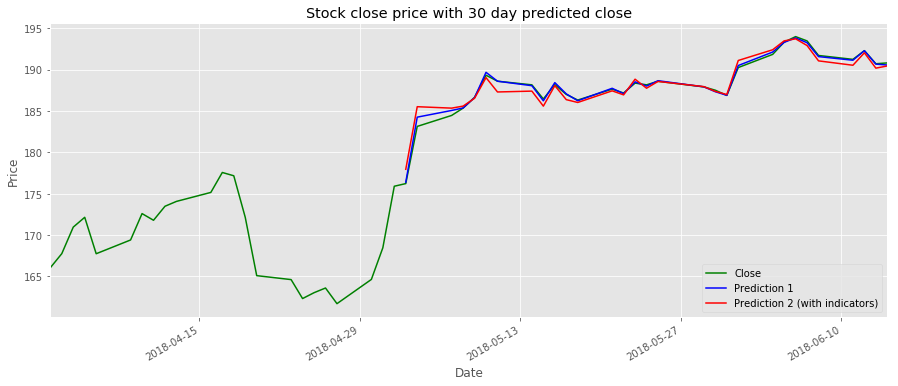

In [70]:
df_plot = pd.DataFrame(df['close'])
df_plot = df_plot.join(result['Predicted'])
df_plot = df_plot.join(resultInd['PredictedInd'])

df_plot['20180401':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green", label='Close') 
df_plot['20180401':pd.to_datetime('today')]['Predicted'].plot(figsize=(15,6), color="blue", label='Prediction 1') 
df_plot['20180401':pd.to_datetime('today')]['PredictedInd'].plot(figsize=(15,6), color="red", label='Prediction 2 (with indicators)') 

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock close price with 30 day predicted close')
plt.show()


# Conclusion
It is amazing to see how machine learning can produce descent results with such little data.  Also, its no surprise that adding random features really did not add much to the model (possibly just added a lot of noise).